In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager
from IPython.display import display

sns.set()
sns.set_style("whitegrid")
color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [3]:
from contextlib import contextmanager
from timeit import default_timer as timer
from typing import Tuple

import gym
import numpy as np
import tensorflow as tf
from gym.spaces import Discrete, Box
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Dense

from spinup.utils.clr import cyclic_learning_rate as clr


@contextmanager
def managed_gym_environment(env_name: str, debug: bool):
    env = gym.make(env_name)
    if debug:
        print('===> Env')

    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    try:
        yield env
    finally:
        env.close()
        if debug:
            print('<=== Env')

In [4]:
env = gym.make('CartPole-v0')

201


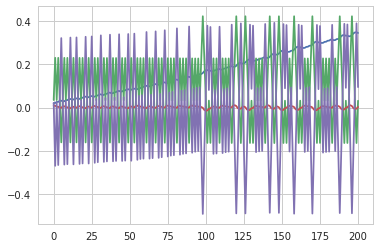

In [96]:
obss = []
observation = env.reset()
obss.append(observation)

for i in range(200):
    cx, cv, pa, pv = observation
    action = 0
    if abs(pv) > .2:
        action = 1 if pv > 0 else 0
    else:
        action = 1 if pa > 0 else 0
    
    observation, _, done, _ = env.step(action)
    env.render()
    obss.append(observation)
    if done:
        break
# observation

def plot_i(xs, obss, i):
    ys = [x[i] for x in obss]
    plt.plot(xs, ys)

score = len(obss)
xs = np.arange(score)
print(score)
plot_i(xs, obss, 0)
plot_i(xs, obss, 1)
plot_i(xs, obss, 2)
plot_i(xs, obss, 3)

In [97]:
env.close()

In [ ]:
class VanillaPolicyGradientRL:
    class _Model:
        def __init__(
                self, observation_shape: Tuple[int, ...], n_actions: int,
                hidden_layers: Tuple[int, ...],
                learning_rate: float = 1e-2, stochasticity: float = .1
        ):
            self._n_actions = n_actions
            self._stochasticity = stochasticity

            # Policy approximate
            self._observation = Input(shape=observation_shape, dtype=tf.float32)
            logits, self._actions = self._get_policy_approx(n_actions, hidden_layers, self._observation)

            # Value-function approximate
            self._value_func_pred = self._get_value_func_approx(hidden_layers, self._observation)

            # Policy loss
            self._actions_phi = tf.placeholder(shape=(None,), dtype=tf.int32)
            self._rewards_phi = tf.placeholder(shape=(None,), dtype=tf.float32)
            self._policy_loss = self._get_policy_loss(
                n_actions, self._rewards_phi, self._actions_phi, logits, self._value_func_pred
            )

            # Value-function loss
            self._value_func_loss = self._get_value_func_loss(self._rewards_phi, self._value_func_pred)

            # Policy learning rate and optimizer
            self._policy_global_step = tf.Variable(0, trainable=False)
            self._policy_learning_rate, self._policy_train_op = self._get_optimizer(
                learning_rate, self._policy_global_step, self._policy_loss
            )

            # Value-function learning rate and optimizer
            self._value_func_global_step = tf.Variable(0, trainable=False)
            self._value_func_learning_rate, self._value_func_train_op = self._get_optimizer(
                learning_rate * 4, self._value_func_global_step, self._value_func_loss
            )

            self._session = tf.InteractiveSession()
            self._session.run(tf.global_variables_initializer())

        @staticmethod
        def _get_policy_approx(
                n_actions: int, hidden_layers: Tuple[int, ...], observation: tf.Variable
        ):
            x = observation
            for hidden_layer in hidden_layers:
                x = Dense(hidden_layer, activation=tf.nn.relu)(x)
            logits = Dense(n_actions)(x)
            actions = tf.squeeze(tf.random.categorical(logits=logits, num_samples=1), axis=1)
            return logits, actions

        @staticmethod
        def _get_value_func_approx(hidden_layers: Tuple[int, ...], observation: tf.Variable):
            x = observation
            for hidden_layer in hidden_layers:
                x = Dense(hidden_layer, activation=tf.nn.relu)(x)
            value_pred = tf.squeeze(Dense(1)(x), axis=1)
            return value_pred

        @staticmethod
        def _get_value_func_loss(rewards_phi: tf.Variable, value_pred: tf.Variable):
            loss = tf.losses.mean_squared_error(rewards_phi, value_pred)
            return loss

        @staticmethod
        def _get_policy_loss(
                n_actions: int, rewards_phi: tf.Variable, actions_phi: tf.Variable, logits: tf.Tensor,
                baseline: tf.Tensor
        ):
            actions_mask = tf.one_hot(actions_phi, n_actions)
            log_probs = tf.nn.log_softmax(logits)
            likelihood = tf.reduce_sum(actions_mask * log_probs, axis=1)
            rewards = rewards_phi - baseline
            loss = -tf.reduce_mean(likelihood * rewards)
            return loss

        @staticmethod
        def _get_optimizer(learning_rate: float, global_step: tf.Variable, loss: tf.Tensor):
            lr = clr(
                global_step=global_step,
                step_size=10,
                learning_rate=(learning_rate, learning_rate * 50),
                const_lr_decay=.5,
                max_lr_decay=.7,
                mode='exp_rate'
            )
            train_op = tf.train.AdamOptimizer(
                learning_rate=lr
            ).minimize(
                loss, global_step=global_step
            )
            return lr, train_op

        def train_one_epoch(self, observations, actions, rewards):
            value_func_loss, _, value_func_learning_rate = self._session.run(
                [self._value_func_loss, self._value_func_train_op, self._value_func_learning_rate],
                feed_dict={
                    self._observation: observations,
                    self._rewards_phi: rewards,
                }
            )
            policy_loss, _, policy_learning_rate = self._session.run(
                [self._policy_loss, self._policy_train_op, self._policy_learning_rate,],
                feed_dict={
                    self._observation: observations,
                    self._actions_phi: actions,
                    self._rewards_phi: rewards,
                }
            )
            return policy_loss, policy_learning_rate, value_func_loss, value_func_learning_rate

        def get_loss(self, observations, actions, rewards):
            loss = self._session.run(
                self._policy_loss,
                feed_dict={
                    self._observation: observations,
                    self._actions_phi: actions,
                    self._rewards_phi: rewards,
                }
            )
            return loss

        def predict_action(self, observations):
            actions_batch = self._session.run(self._actions, {
                self._observation: observations.reshape(1, -1)
            })
            action = actions_batch[0]
            if np.random.rand() < self._stochasticity:
                # action = self._sample_another_action(action)
                action = np.random.randint(self._n_actions)
            return action

        def _sample_another_action(self, action):
            a = np.random.randint(self._n_actions - 1)
            return a if a < action else a + 1

    class _Sampler:
        def __init__(self, env, n_episodes, max_total_steps, render: bool = True):
            self._env = env
            self._n_episodes = n_episodes
            self._max_total_steps = max_total_steps
            self._render = render

            self._actions = np.empty(shape=(max_total_steps,), dtype=np.int32)
            self._rewards = np.empty(shape=(max_total_steps,), dtype=np.float32)
            self._current_rewards = np.empty(shape=(max_total_steps,), dtype=np.float32)
            self._episode_scores = np.empty(shape=(n_episodes,), dtype=np.float32)
            self._episode_lengths = np.empty(shape=(n_episodes,), dtype=np.int32)

            observation = self._env.reset()
            observations_shape = (max_total_steps,) + observation.shape
            self._observations = np.empty(shape=observations_shape, dtype=np.float32)

        def get_one_epoch_samples(self, model: 'VanillaPolicyGradientRL._Model'):
            step, episode, done, ep_step = 0, 0, False, 0
            observation = self._env.reset()

            while step < self._max_total_steps and episode < self._n_episodes:
                if episode == 0 and self._render:
                    self._env.render()

                self._observations[step] = observation.copy()

                action = model.predict_action(observation)
                self._actions[step] = action

                observation, reward, done, _ = self._env.step(action)
                self._current_rewards[ep_step] = reward

                ep_step += 1
                step += 1
                if done:
                    observation = self._env.reset()
                    score = self._current_rewards[:ep_step].sum()
                    self._rewards[(step - ep_step):step] = self._reward_to_go(
                        self._current_rewards[:ep_step]
                    )
                    self._episode_scores[episode] = score
                    self._episode_lengths[episode] = ep_step

                    episode += 1
                    ep_step = 0
                    if (
                            step > .95 * self._max_total_steps
                            or step + ep_step > .99 * self._max_total_steps
                    ):
                        break

            observations = self._observations[:step - ep_step]
            actions = self._actions[:step - ep_step]
            rewards = self._rewards[:step - ep_step]
            episode_scores = self._episode_scores[:episode]
            episode_lengths = self._episode_lengths[:episode]

            return observations, actions, rewards, episode_scores, episode_lengths

        def _reward_to_go(self, rewards):
            return np.cumsum(rewards[::-1])[::-1]

    def __init__(self, env_name: str, debug: bool = False):
        self.env_name = env_name
        self.debug = debug

    def run_train(
            self,
            hidden_layers: Tuple[int], epochs: int,
            epoch_episodes: int, epoch_steps: int,
            learning_rate: float, render: bool
    ) -> None:
        with managed_gym_environment(self.env_name, self.debug) as env:
            observation_shape = env.observation_space.shape
            n_actions = env.action_space.n

            model = self._Model(
                observation_shape, n_actions,
                hidden_layers=hidden_layers,
                learning_rate=learning_rate,
                stochasticity=.0
            )
            sampler = self._Sampler(
                env=env,
                n_episodes=epoch_episodes,
                max_total_steps=epoch_steps,
                render=render
            )
            for epoch in range(epochs):
                observations, actions, rewards, episode_scores, episode_lengths = sampler.get_one_epoch_samples(model)

                if episode_scores.shape[0] == 0:
                    continue

                t = timer()
                loss, lr, vf_loss, vf_lr = model.train_one_epoch(
                    observations=observations,
                    actions=actions,
                    rewards=rewards
                )
                dt = 1e7 * (timer() - t) / observations.shape[0]

                model._stochasticity *= .0

                mean_score = episode_scores.mean()
                mean_length = episode_lengths.mean()
                print('[{0}]: loss: {1:.3f}  sc: {2:.3f}  len: {3:.3f}  t: {4:.4f}  lr:{5:.4f}  vfl: {6:.3f}'.format(
                    epoch, loss, mean_score, mean_length, dt, lr, vf_loss
                ))

            if render:
                input()


if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument('--env_name', '--env', type=str, default='CartPole-v0')
    parser.add_argument('--debug', action='store_true')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--epoch_episodes', type=int, default=100)
    parser.add_argument('--epoch_steps', type=int, default=1000)
    parser.add_argument('--lr', type=float, default=1e-2)
    parser.add_argument('--render', action='store_true')
    args = parser.parse_args()

    debug = args.debug
    if not debug:
        print('\nUsing simplest formulation of policy gradient.\n')

    VanillaPolicyGradientRL(args.env_name, debug=debug).run_train(
        hidden_layers=(32,),
        epochs=args.epochs,
        epoch_episodes=args.epoch_episodes,
        epoch_steps=args.epoch_steps,
        learning_rate=args.lr,
        render=args.render
    )